In [1]:
# add root dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
root_dir = os.path.dirname(parent_dir)
sys.path.insert(0, root_dir)

# Imports 

In [2]:
# own imports
from imageGenerators import load_digits, load_realdata
from imageGenerators.imgGen_simple import synth_generator
from models.cyclegan_modified.cyclegan import cyclegan
import models.common_functions 
# librarys
import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

# Parameters 

In [4]:
N_IMAGES = 50
N_TEST = 50

EPOCHS = 4

N_DIGITS = 5
BATCH_SIZE = 1
BUFFER_SIZE = 1000

# all images will be resized to these dimensions
#                  width, height
IMAGE_DIMENSIONS = (512, 128)
#IMAGE_DIMENSIONS = (256, 256)
GRAYSCALE = True
N_CHANNELS = 1 if GRAYSCALE else 3
#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

#CHECKPOINTPATH = Path("D:/m2/savedmodels/test")
#CHECKPOINTPATH = None # dont save model
CHECKPOINTPATH = Path("D:/m2/savedmodels/cgan_midstate_pools")
modelEpoch = 10

# generate synthetic images (Domain A)

In [5]:
def generate_synthetic(show_generated=0, digits = None):
    # init imagegenerator
    synthGenerator = synth_generator(vertical_margin=20)
    
    # how far can a digit be scrolled down for it to be considered midstate/normalstate
    midstate_range=(0.3,0.7) # scrolling down so much that two digits are on screen
    normalstate_range=(-0.2,0.2) # scrolling up or down a little keeps normalstate

    # prepare inputdigits 
    #digitsTrain = np.random.randint(0,20,size=(N_IMAGES, N_DIGITS))
    digitsTest = np.random.randint(0,20,size=(N_TEST, N_DIGITS)) if digits is None else digits
    
    # params to imagegenerator
    margins = 20 # distances between digits
    border = (2, 2, 2, 2) # padding of resultimage
    height = IMAGE_DIMENSIONS[1]; width= IMAGE_DIMENSIONS[0] # dimensions to resize result to
    # generate images
    #synthTrain = synthGenerator.generate_images(digitsTrain, margins, border, width, height, range_normal=normalstate_range,range_midstate=midstate_range)
    synthTest = synthGenerator.generate_images(digitsTest, margins, border, width, height, range_normal=normalstate_range,range_midstate=midstate_range)
    
    
    return  synthTest, digitsTest

# load real images (Domain B)

In [6]:
images_easy, labels_easy = load_realdata.load_wmr_easy(resizeTo=IMAGE_DIMENSIONS)

C:\Users\andre\jupyter_ws\imageGenerators\load_realdata.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


In [7]:
synthTest, digitsTest = generate_synthetic()

# Preprocess inputs

In [8]:
cgModel = cyclegan(IMAGE_SHAPE, checkpoint_path=CHECKPOINTPATH, load_checkpoint_after_epoch=modelEpoch)

test_A = tf.data.Dataset.from_tensor_slices(synthTest)\
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_B = tf.data.Dataset.from_tensor_slices(images_easy)\
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)

loaded checkpoint:  D:\m2\savedmodels\cgan_midstate_pools\epoch-10


C:\Users\andre\Miniconda3\envs\keras_gpu\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


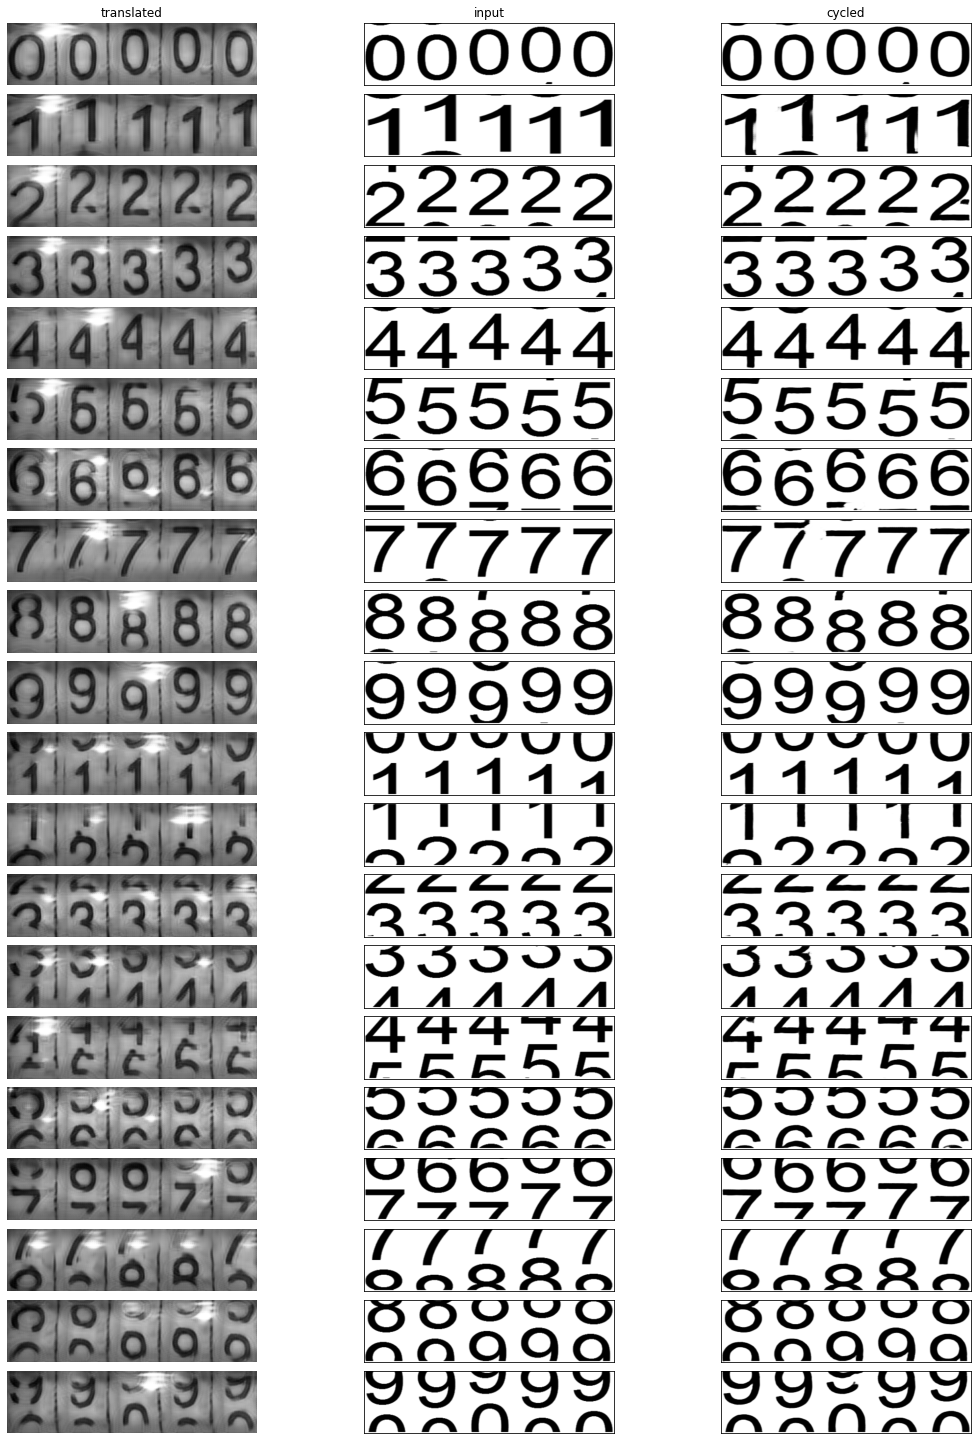

In [45]:
digits = [
    [value for _ in range(N_DIGITS)] for value in range(0,20)
]

synthImages, _ = generate_synthetic(digits=digits)
dataset = tf.data.Dataset.from_tensor_slices(synthImages)\
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
translatedImages = cgModel.gen_AtoB.predict(dataset)
cycledImages = cgModel.gen_BtoA.predict(translatedImages)

width = 16
height=20*1
fig, a = plt.subplots(20,3, figsize=(width,height), linewidth=1)
for i in range(0,20):
    a[i][0].imshow(translatedImages[i,:,:,0], cmap="gray")
    a[i][0].axis("off")
    
    a[i][1].imshow(synthImages[i,:,:], cmap="gray")
    a[i][1].axes.get_xaxis().set_ticks([])
    a[i][1].axes.get_yaxis().set_ticks([])
    
    a[i][2].imshow(cycledImages[i,:,:,0], cmap="gray")
    a[i][2].axes.get_xaxis().set_ticks([])
    a[i][2].axes.get_yaxis().set_ticks([])
a[0][0].set_title("translated")
a[0][1].set_title("input")
a[0][2].set_title("cycled")
fig.tight_layout(pad=0.5)
fig.show()

C:\Users\andre\Miniconda3\envs\keras_gpu\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


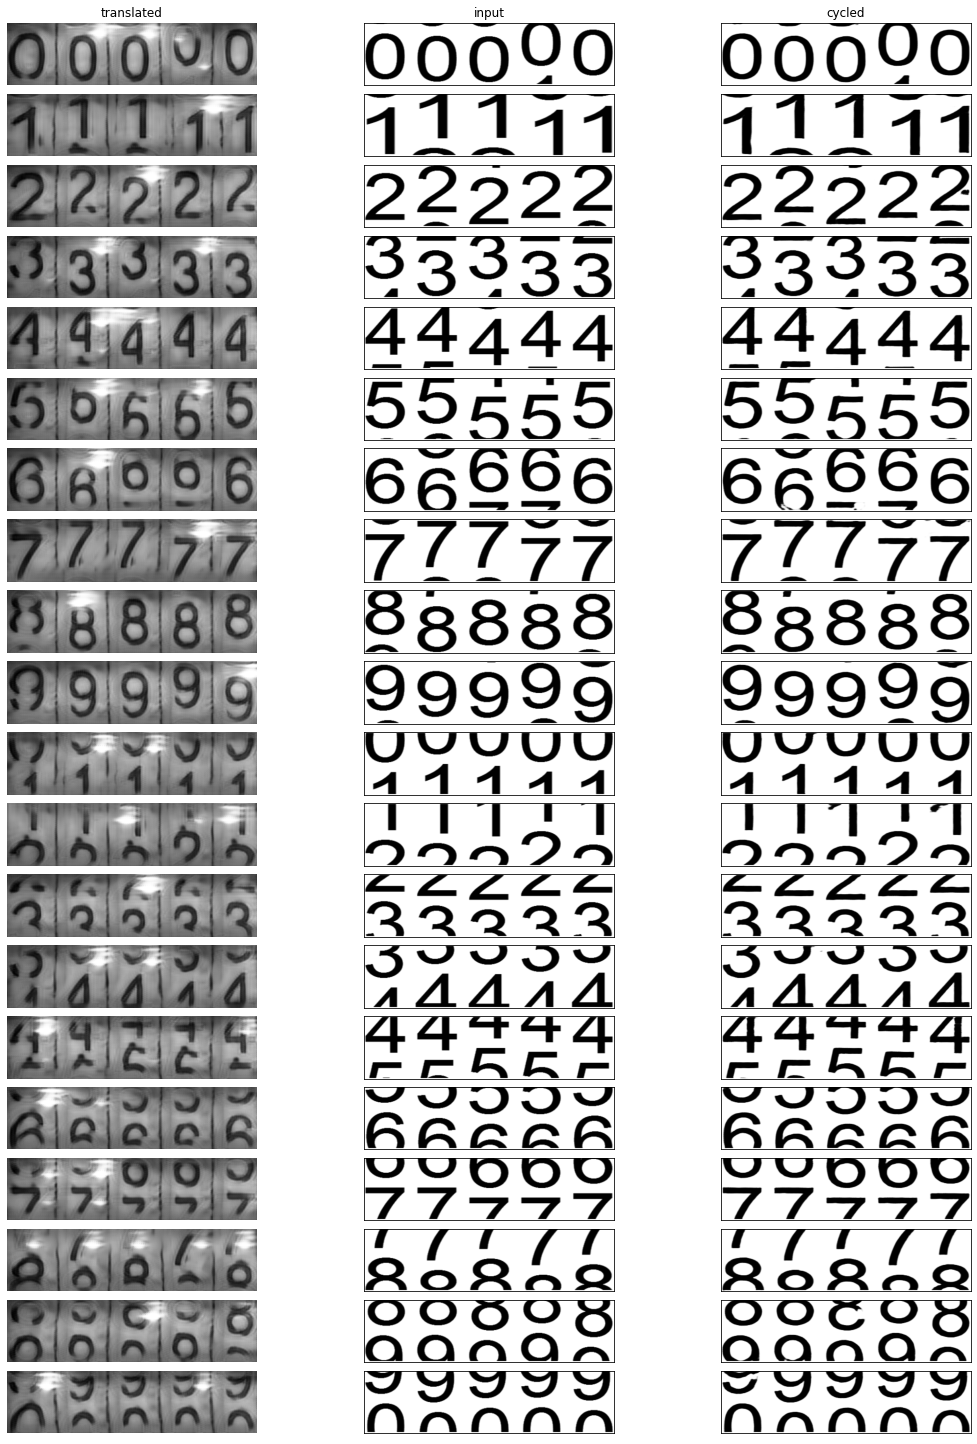

In [43]:
width = 16
height=20*1

fig, a = plt.subplots(20,3, figsize=(width,height), linewidth=1)
for value in range(0,20):
    digits = [
        [value for _ in range(N_DIGITS)]
    ]
    synthImages, _ = generate_synthetic(digits=digits)
    dataset = tf.data.Dataset.from_tensor_slices(synthImages)\
        .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
    translatedImages = cgModel.gen_AtoB.predict(dataset)
    cycledImages = cgModel.gen_BtoA.predict(translatedImages)
    
    a[value][0].imshow(translatedImages[0,:,:,0], cmap="gray")
    a[value][0].axis("off")
    
    a[value][1].imshow(synthImages[0,:,:], cmap="gray")
    a[value][1].axes.get_xaxis().set_ticks([])
    a[value][1].axes.get_yaxis().set_ticks([])
    
    a[value][2].imshow(cycledImages[0,:,:,0], cmap="gray")
    a[value][2].axes.get_xaxis().set_ticks([])
    a[value][2].axes.get_yaxis().set_ticks([])

a[0][0].set_title("translated")
a[0][1].set_title("input")
a[0][2].set_title("cycled")
fig.tight_layout(pad=0.5)
fig.show()
    

In [9]:
translated = cgModel.gen_AtoB.predict(test_A)

[ 8 16 13  6 10]


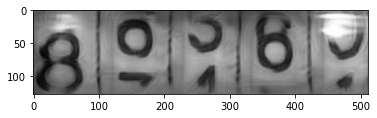

[13 12  6 19 15]


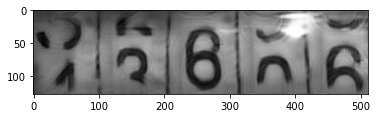

[ 1  9 11 14 17]


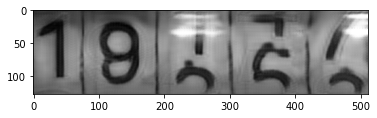

[14  2 13 11  7]


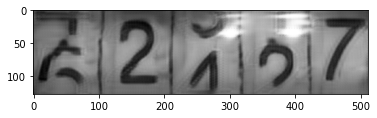

[14  4 13 15 15]


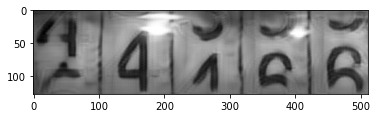

[14  5 14  1  5]


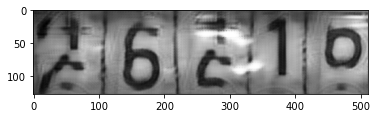

[11  4 11 10 19]


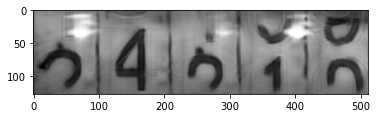

[ 9 16 10 10 13]


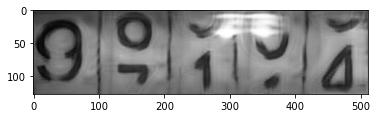

[ 5  8 18  3 11]


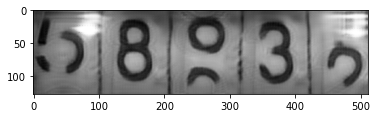

[ 8 13  8  7 13]


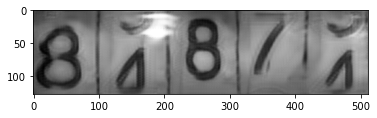

[15  5  4  3 14]


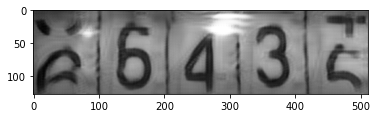

[ 3 13 13  0 12]


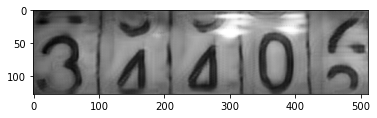

[6 5 1 8 5]


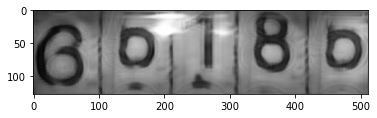

[ 1 10  9 15 13]


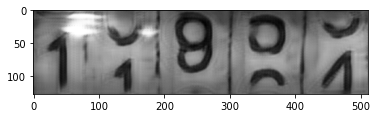

[ 3  1 17 13 19]


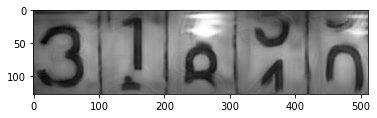

[13 16 14 12  3]


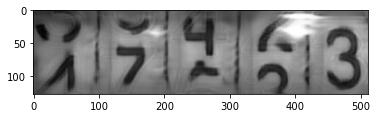

[ 4 12 14 11  4]


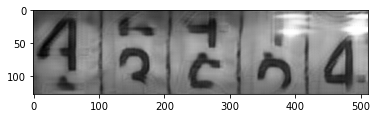

[14 16 12  5 19]


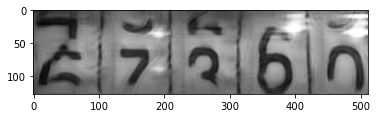

[ 3 14 12 18  9]


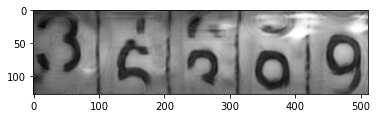

[19 15  9 18  5]


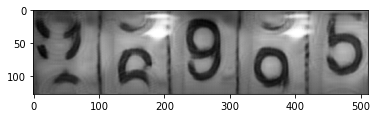

[15  2  5 14 12]


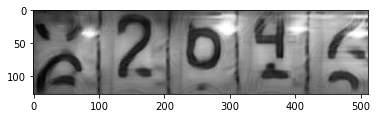

[10  3 18  4 12]


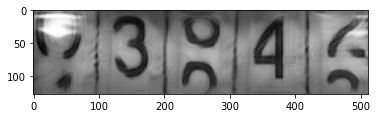

[6 2 2 8 0]


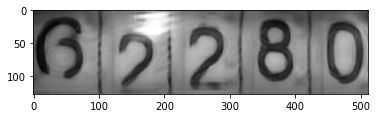

[17  2 13 13 17]


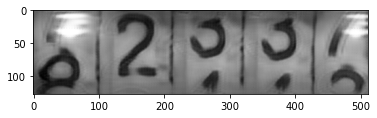

[18 16 16  2  6]


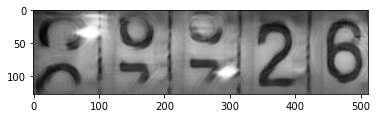

[ 4 18 10 14 13]


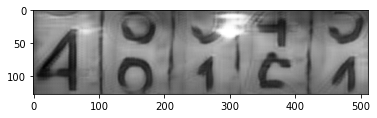

[ 4 14 19 11  1]


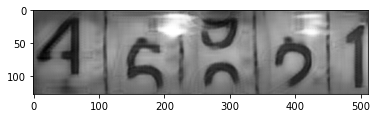

[19  9 17  6  4]


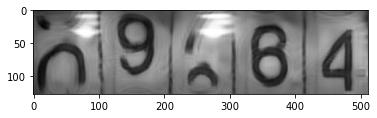

[ 9  2  2 11 12]


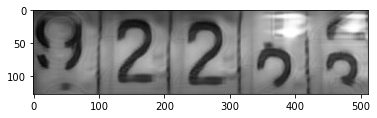

[16  5  3 14  4]


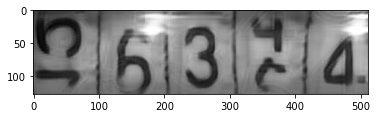

[18 15 11 19 16]


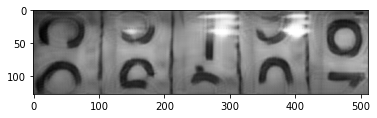

[12  0 17  4 19]


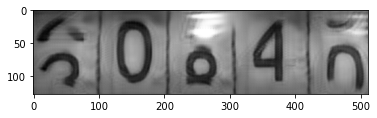

[17 17  4 14 18]


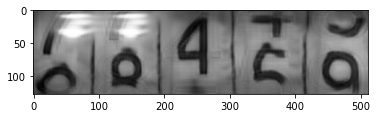

[18  5 14 11 19]


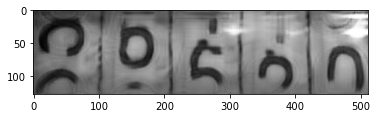

[ 2 15 16 19 12]


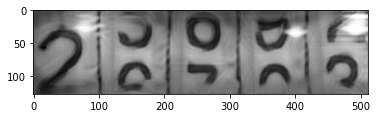

[ 7  3 12  1  8]


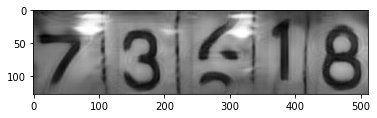

[ 4  7  3  4 12]


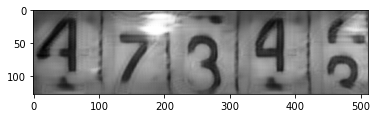

[ 2 13  8 12  0]


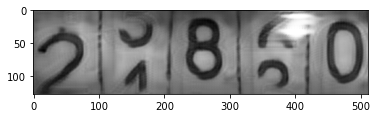

[14  9 11  7  6]


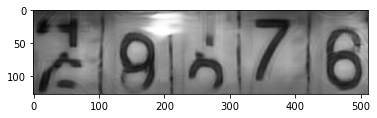

[ 5 16  5 12 18]


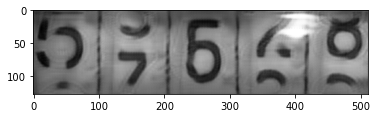

[ 8  5  9  8 17]


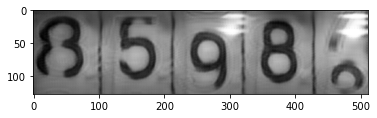

[17 12  9 10 13]


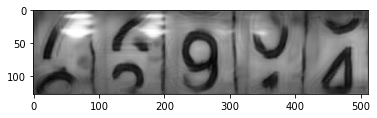

[13  5 16  3 19]


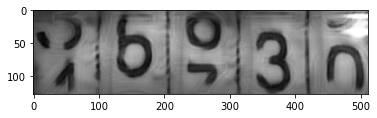

[17 11 16  3  2]


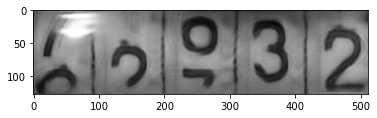

[ 2 12 16 14  9]


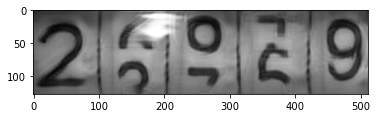

[ 3  9  0  2 16]


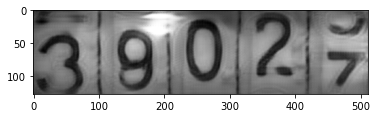

[ 8 18 10 18  4]


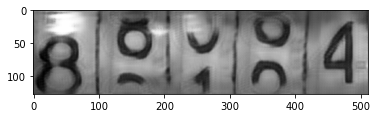

[15  2  7  3 13]


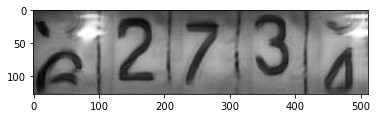

[ 1 19  3 11  0]


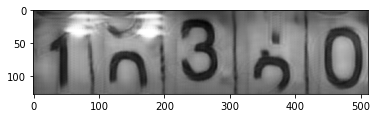

[ 8  1  5 10  7]


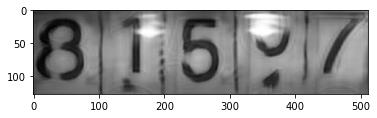

In [10]:
for i, image in enumerate(translated):
    print(digitsTest[i])
    plt.imshow(image[:,:,0], cmap="gray")
    plt.show()